<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:/Users/Anna/Downloads/C6_UserID/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [7]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    items = sorted(glob(path_to_csv_files + '/*.csv'))
    site_list = []
    column_names = feature_names 
    out = []
   
    
   #открываем словарь
    with open(site_freq_path, 'rb') as f:
        freq_id =  pickle.load(f)
    
    
    
    a = 0
    b = 0
    user_counter = 0
    session_counter = 0
    real_session_length = 0
    for item in tqdm_notebook(items):
        user_counter = int(os.path.basename(item) [4:8])
        df = pd.read_csv(item)
        #преобразуем данные по дате-времени в объект datetime
        sites_time =  df.timestamp.apply(pd.to_datetime)
        for sess in range(0, int(np.ceil( len(df.site)/window_size) )):
            a = sess*window_size
            b = a + session_length
            #добавляем посещенные сайты
            one_row = [freq_id [key][0] for key in df.site.values [a:b]] 
            #считаем уникальные сайты
            unique_sites = np.unique(one_row).shape[0]
            #обработка сессии, если ее длина< session_length
            addition = 0
            real_session_length = len(one_row)
            if real_session_length < session_length:
                addition = session_length - real_session_length
                one_row.extend([0]*addition)
                
            
           
           # добавляем признаки time_diff
            for t in range(a,a + (real_session_length-1)):
                var = int ((sites_time.values[t+1] -sites_time.values[t]) / np.timedelta64(1, 's'))
                one_row.append(var)
            one_row.extend([0] * (addition))
            

            #добавляем признак session_timespan
            one_row.append ( int(   (max(sites_time[a:b]) - min(sites_time[a:b]) )  / np.timedelta64(1, 's') ) )
            #добавляем число уникальных сайтов
            one_row.append(unique_sites)
            #добавляем признак start_hour
            one_row.append(min(sites_time[a:b].dt.hour))
            #добавляем признак, соответствующий дню недели
            one_row.append(min(sites_time[a:b].dt.weekday))
            #записываем номер пользователя
            one_row.append(user_counter)
            out.append(one_row)
            one_row = []
            session_counter+=1
    #получаем dataframe   
    df_out = pd.DataFrame(out, columns = column_names)
    
    return df_out
    

**Проверим функцию на игрушечном примере.**

In [8]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [9]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [ ]:
#проверка пройдена

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 41.5 s


In [11]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


In [12]:
train_data_10users [['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']].values

array([[ 33,   5,   8,   4],
       [284,  10,   8,   4],
       [258,   7,   8,   4],
       ...,
       [ 16,   6,  15,   2],
       [242,   5,  15,   2],
       [  0,   2,  15,   2]], dtype=int64)

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [50]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 3min 7s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [390]:
new_features_10users = train_data_10users [['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']].values
new_features_150users = train_data_150users [['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']].values

In [391]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
int(np.median(train_data_10users.session_timespan))

37

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
int(np.median(train_data_10users.day_of_week)) # Wednesday

2

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [321]:
int(np.median(train_data_150users.start_hour))

13

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [394]:
int(np.median(train_data_150users['#unique_sites'])) 

7

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [19]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [399]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,John
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,John
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,John
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,John
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,John


In [36]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

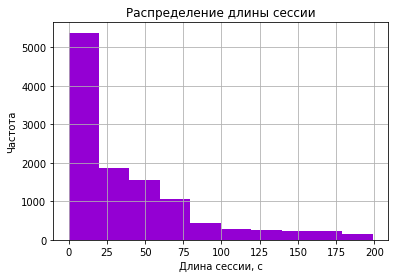

In [336]:
plt.hist(train_data_10users [train_data_10users.session_timespan < 200] ['session_timespan'], color = 'darkviolet')
plt.xlabel(u'Длина сессии, c')
plt.ylabel(u'Частота')
plt.title(u'Распределение длины сессии')
plt.grid(True)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

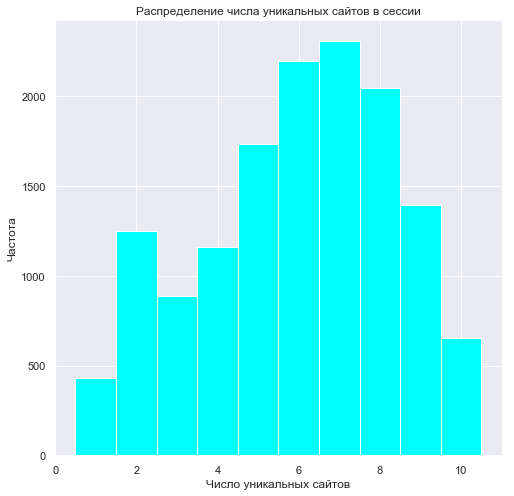

In [541]:

plt.hist(train_data_10users ['#unique_sites'], bins = np.arange(0.5,11.5,1),color = 'aqua')
plt.xlabel(u'Число уникальных сайтов')
plt.ylabel(u'Частота')
plt.title(u'Распределение числа уникальных сайтов в сессии')
plt.grid(True)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

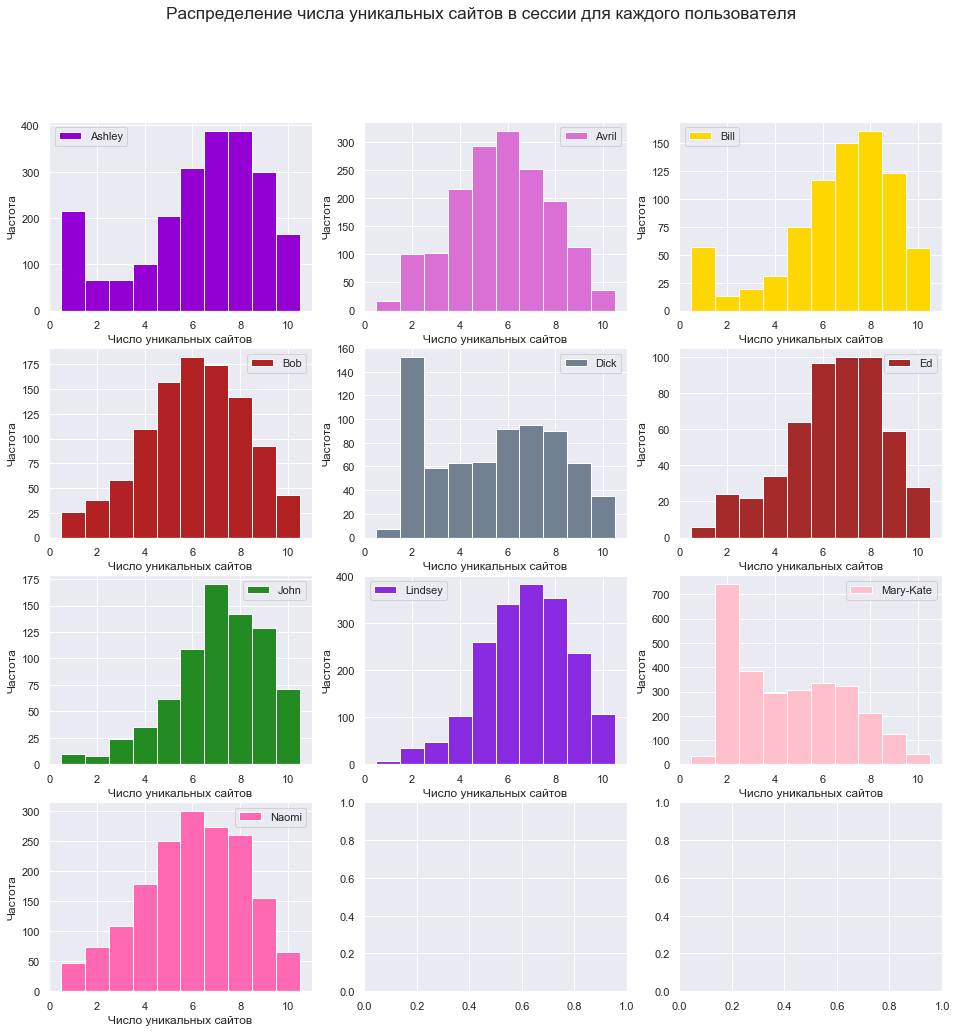

In [542]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))



   
fig.suptitle(u'Распределение числа уникальных сайтов в сессии для каждого пользователя', fontsize="x-large")
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    plt.subplot(4, 3, idx+1)
    plt.hist(sub_df ['#unique_sites'], bins = np.arange(0.5,11.5,1), color = color_dic[user])
    plt.xlabel(u'Число уникальных сайтов')
    plt.ylabel(u'Частота')
    plt.legend ([user])
    plt.grid(True)
    

        

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

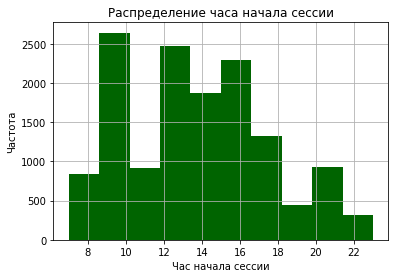

In [60]:
plt.hist(train_data_10users ['start_hour'],color = 'darkgreen')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Частота')
plt.title(u'Распределение часа начала сессии')
plt.grid(True)
plt.show()


In [565]:
print(min(train_data_10users ['start_hour']),max(train_data_10users ['start_hour']))

7 23


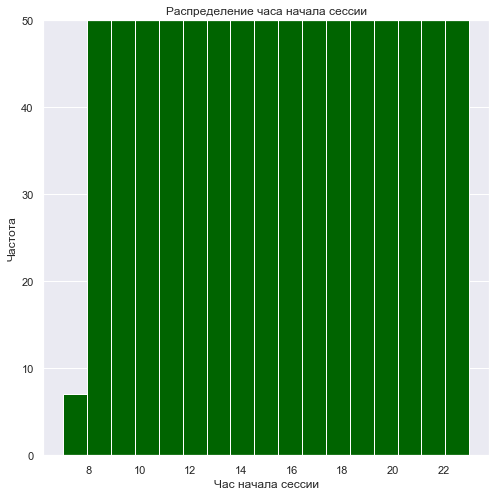

In [579]:
#визульно убедимся, что есть сессии, соответсвующие 7 часам
plt.hist(train_data_10users ['start_hour'], bins = 17, color = 'darkgreen')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Частота')
plt.title(u'Распределение часа начала сессии')
plt.ylim([0,50])
plt.grid(True)
plt.show()


**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

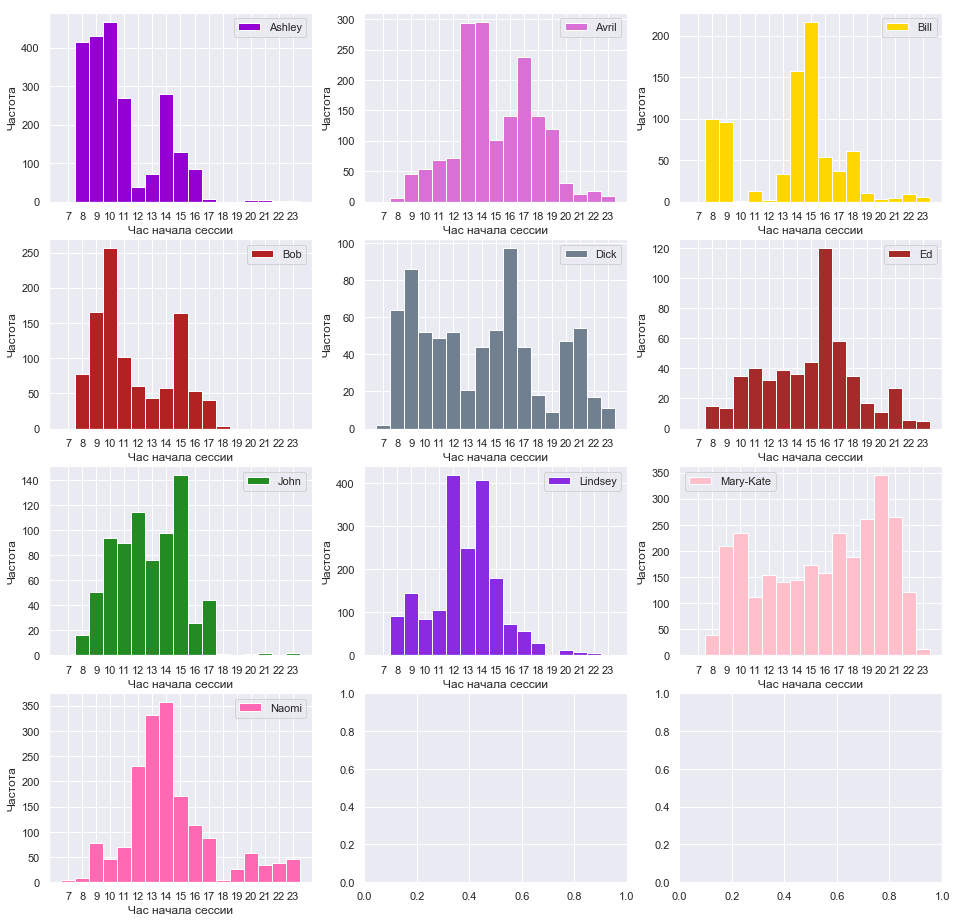

In [558]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))


for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    plt.subplot(4, 3, idx+1)
    plt.hist(sub_df ['start_hour'], bins = np.arange(6.5,24.5,1), color = color_dic[user])
    plt.xlabel(u'Час начала сессии')
    plt.ylabel(u'Частота')
    plt.xticks(range(7,24,1))
    plt.legend ([user])
    plt.grid(True)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

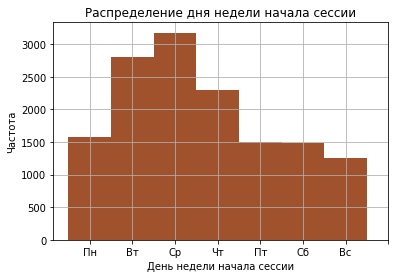

In [534]:
plt.hist(train_data_10users ['day_of_week'], bins =np.arange(-0.5,7.5,1), color = 'sienna')
plt.xticks(range(8), [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
plt.xlabel(u'День недели начала сессии')
plt.ylabel(u'Частота')
plt.title(u'Распределение дня недели начала сессии')
plt.grid(True)
plt.show()


**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

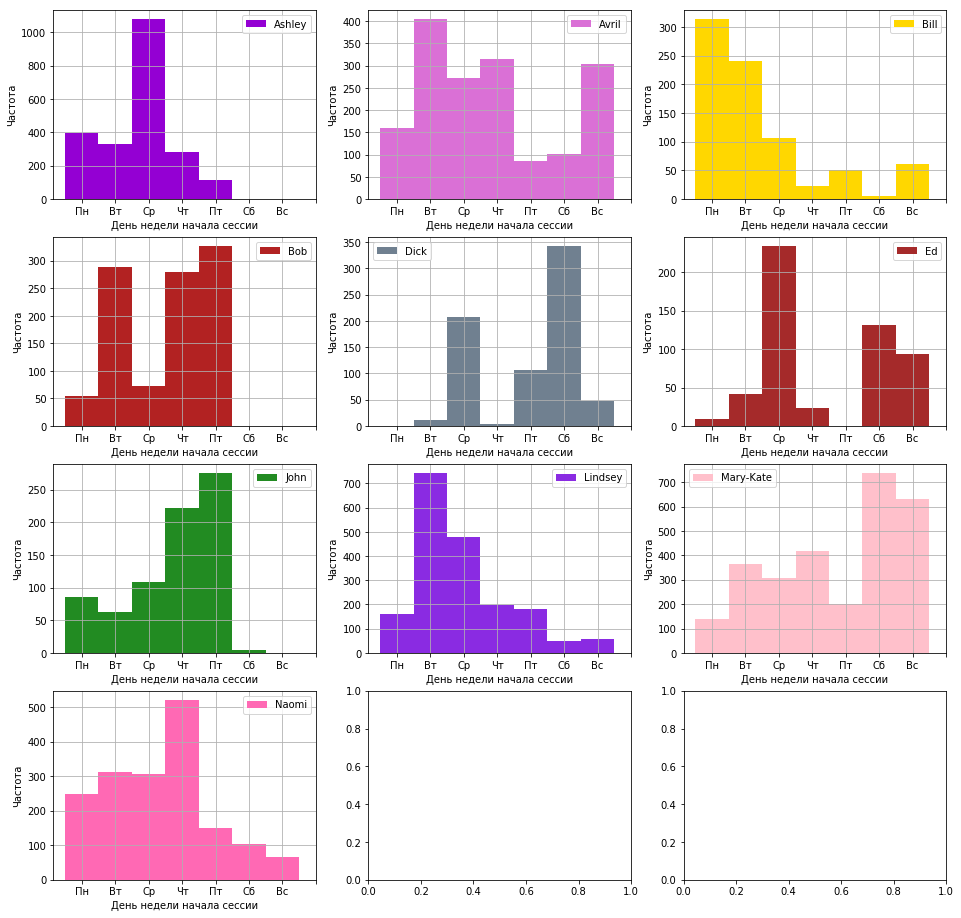

In [508]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))


for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    plt.subplot(4, 3, idx+1)
    plt.hist(sub_df ['day_of_week'], bins = np.arange(-0.5,7.5,1),color = color_dic[user])
    
    plt.xticks(range(8), [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
   
    
    plt.xlabel(u'День недели начала сессии')
    plt.ylabel(u'Частота')
    plt.legend ([user])
    plt.grid(True)


**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Для начала отметим, что все пользователи не начинают сессии ночью. Минимальный и максимальный час начала сессии - 7 и 23, соответственно. Почти все сессии длятся меньше 3 минут.

Ashley: этот пользователь активен только по будням, больше всего в среду; активно начинает сессии  с 7 до 11 и с 14 до 15 часов включительно, меньшая активность в 13-14 часов, часы незначительной активности - 17, 20 и 21. В основном, посещает 5-9, либо 1 уникальный сайт.

Avril: пользователь активен в течении всей неделе, некоторый спад - в пятницу и в субботу; начинает сессии с утра до вечера, больше всего в 13-14 и 17-18 часов. Чаще всего посещает 4-8 уникальных сайтов за сессию.

Bill: Активен в понедельник, вторник и среду, меньшая активность - четверг, пятница и воскресенье, по субботам в сети почти не бывает.Начинает сессии в 8-9 и в 13-18 часов, в остальное время активность относительно незначительна. По числу уникальных сайтов похож на Ashley.

Bob: Активен исключительно в будни, причем во вт, чт и пт значительно больше, чем в пн и ср; посещает сайты с с 8 до 18 часов, "горячие часы" - 9,10 и 15. В основном посещает 4-9 уникальных сайтов.

Dick: Пик недельной активности - суббота, меньшая активность в ср, пт и воскр, по вт и чт почти не бывает, по пон в сети замечен не был. Бывает в интернете с 7 до 23 часов, больше всего в 9 и в 16 часов, на одном уникальном сайте за сессию почти не останавливается, чаще всего останавливается на 2-х,  реже просматривает 3-10 уникальных сайтов.

Ed: Бывает в интернете во все дни недели, кроме пятницы, больше всего в среду, субботу и в воскресенье, меньше всего в пон; активен в течении всего дня, пик - 16 часов; чаще всего открывает 5-9 уникальных сайтов за сессию.

John: Активен в сети по будням, активность увеличивает отпон к пт, в выходные в сети почти не бывает; бывает в сети с 8 до 17 часов; посещает, в основном, 5-10 сайтов за сессию.

Lindsey: пользователь активен в течение всей недели, больше всего по вт и ср; c 8 до 18 ч; посещает, преимущественно, 5-9 уникальных сайтов за сессию.

Mary-Kate: активен в течение всей недели, больше всего на выходных; c 8 до 22 часов, утром и вечером активность более выражена; предпочитает посещать 2 уникальных сайта за сессию, но может и больше.

Naomi: активен в течение всей недели, преимущественно в будни, особенно в четверг; пики активности в 12-16 ч, менее активен утром и вечером; обычно посещает 4-9 уникальных сайтов за сессию.

Общий вывод - каждый пользователь имеет свой уникальный профиль взаимодействия с интернетом.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [453]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
        site_freq_10 =  pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [480]:
top10_sites = list(site_freq_10) [:10]
top10_freqs =  [site_freq_10 [key][1] for key in top10_sites]
print (list(zip(top10_sites,top10_freqs)))

[('s.youtube.com', 8300), ('www.google.fr', 7813), ('www.google.com', 5441), ('mail.google.com', 4158), ('www.facebook.com', 4141), ('apis.google.com', 3758), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 3244), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 3094), ('plus.google.com', 2630), ('accounts.google.com', 2089)]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

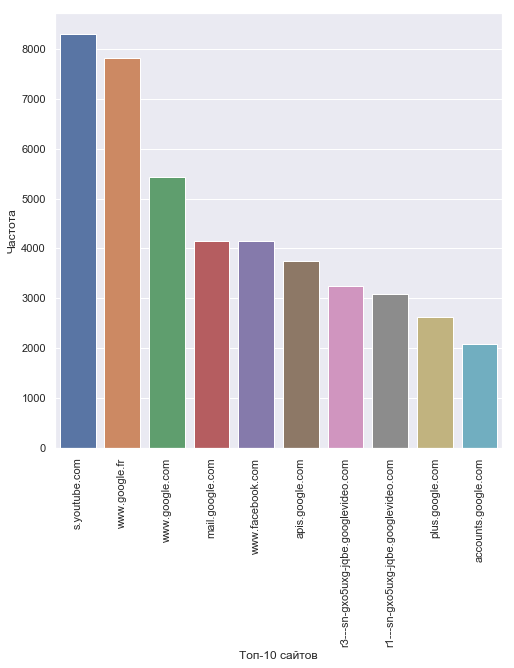

In [538]:
sns.set(rc={'figure.figsize':(8,8)})
sns.barplot ( x = top10_sites , y = top10_freqs  )
plt.xlabel(u'Топ-10 сайтов')
plt.ylabel(u'Частота')
plt.xticks(rotation='vertical')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [15]:
# пробуем признак, характеризующий склонность смотреть видео на youtube, и признак - время суток начала сессии - утро, день, вечер.
new_feature_names = ['youtube_portion','time', 'user_id']


In [16]:

def feature_engineering(path_to_csv_files, site_freq_path, new_feature_names, session_length=10, window_size=10):
    items = sorted(glob(path_to_csv_files + '/*.csv'))
    site_list = []
    out = []
    one_row = []
   
    
   
    with open(site_freq_path, 'rb') as f:
        freq_id =  pickle.load(f)
    
    
    
    a = 0
    b = 0
    user_counter = 0
    session_counter = 0
    real_session_length = 0
    for item in tqdm_notebook(items):
        user_counter =int(os.path.basename(item) [4:8])
        df = pd.read_csv(item)
        sites_time =  df.timestamp.apply(pd.to_datetime)
        for sess in range(0, int(np.ceil( len(df.site)/window_size) )):
            youtube_counter = 0
            out_1line =[]
            a = sess*window_size
            b = a + session_length
            one_row = [freq_id [key][0] for key in df.site.values [a:b]] 
            unique_sites = np.unique(one_row).shape[0]
            addition = 0
            real_session_length = len(one_row)
            if real_session_length < session_length:
                addition = session_length - real_session_length
                one_row.extend([0]*addition)
               
                   
                     
            
            for el in df.site.values [a:b]:
                if el.find('youtube') != -1:
                    youtube_counter+=1
            out_1line.append(youtube_counter/real_session_length)
            
            if  (7 <= min(sites_time[a:b].dt.hour) <= 11):
                out_1line.append(0)
            elif (12 <= min(sites_time[a:b].dt.hour) <= 17):
                out_1line.append( 1)
            elif (18 <= min(sites_time[a:b].dt.hour) <= 23):
                out_1line.append( 2)          
                               
            out_1line.append(user_counter)
            out.append(out_1line)
            
            #y.append(user_counter)
            one_row = []
            session_counter+=1
        
    df_out = pd.DataFrame(out, columns = new_feature_names)
    
    return df_out

In [17]:
%%time
new_features_10users_fe = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  new_feature_names=new_feature_names, session_length=10)


Wall time: 29 s


In [20]:
new_features_10users['target'] = new_features_10users['user_id'].map(id_name_dict)

In [51]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  new_feature_names=new_feature_names, session_length=10)


Wall time: 1min 59s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

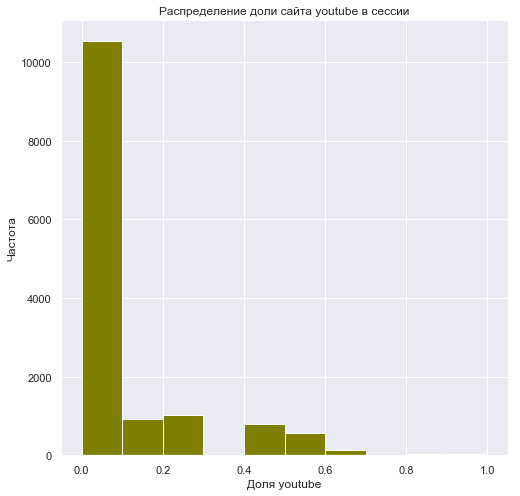

In [664]:
plt.hist(new_features_10users ['youtube_portion'],  color = 'olive')

plt.xlabel(u'Доля youtube')
plt.ylabel(u'Частота')
plt.title(u'Распределение доли сайта youtube в сессии')
plt.grid(True)
plt.show()


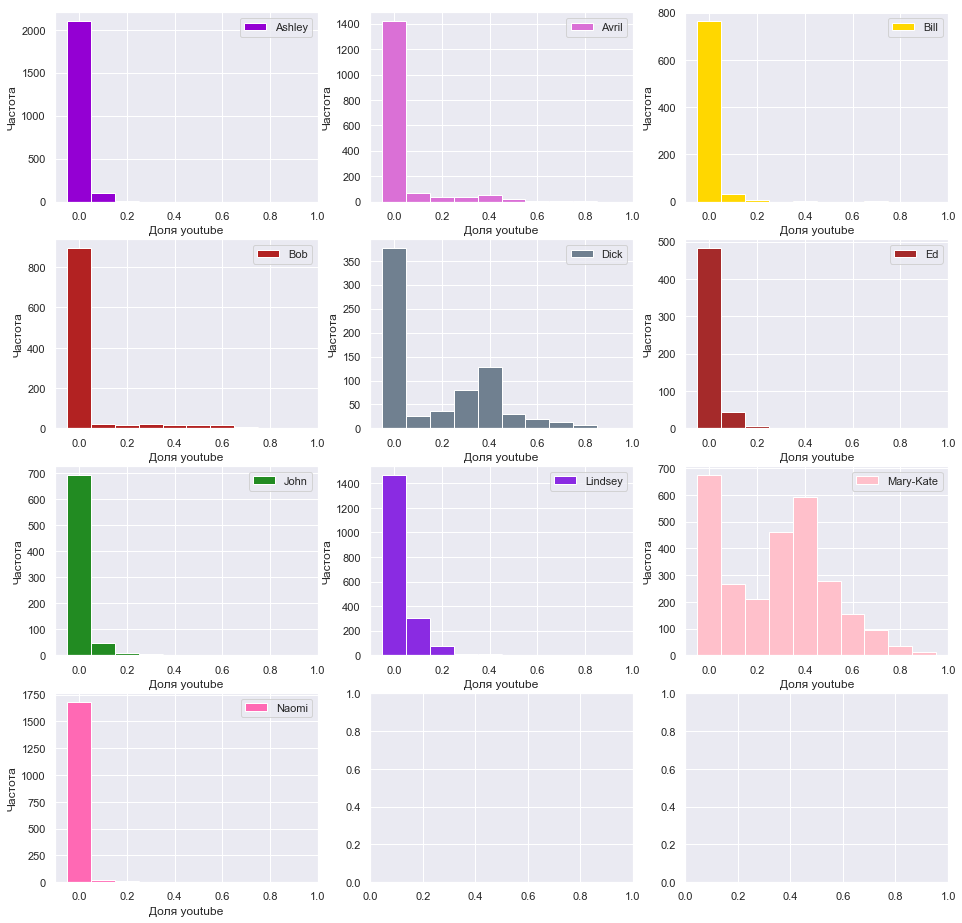

In [702]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))


for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    plt.subplot(4, 3, idx+1)
    plt.hist(sub_df ['youtube_portion'], bins = np.arange(-0.05,1.05,0.1), color = color_dic[user])
    plt.xlabel(u'Доля youtube')
    plt.ylabel(u'Частота')
    plt.legend ([user])
    plt.grid(True)

Итак, среди 10 пользователей мы нашли пользователей, которые любят смотреть youtube - Mary-Kate и, в некоторой степени, Dick и Lindsey. Признак оставляем, потенциально он может помочь индентифицировать пользователя.

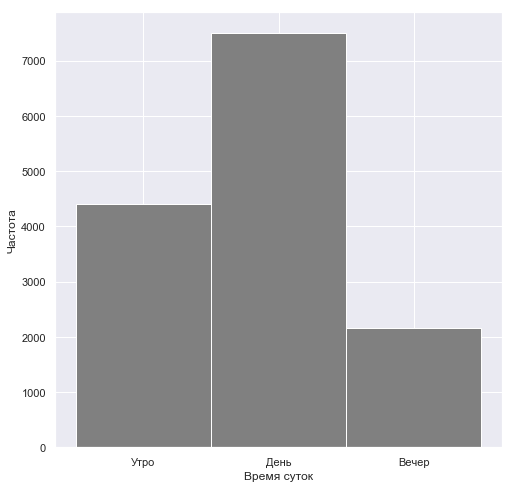

In [675]:
plt.hist(new_features_10users ['time'], bins =  np.arange(-0.5,3.5,1), color = 'grey')

plt.xlabel(u'Время суток')
plt.ylabel(u'Частота')
plt.xticks(range(3), [u'Утро', u'День', u'Вечер'])
plt.grid(True)
plt.show()

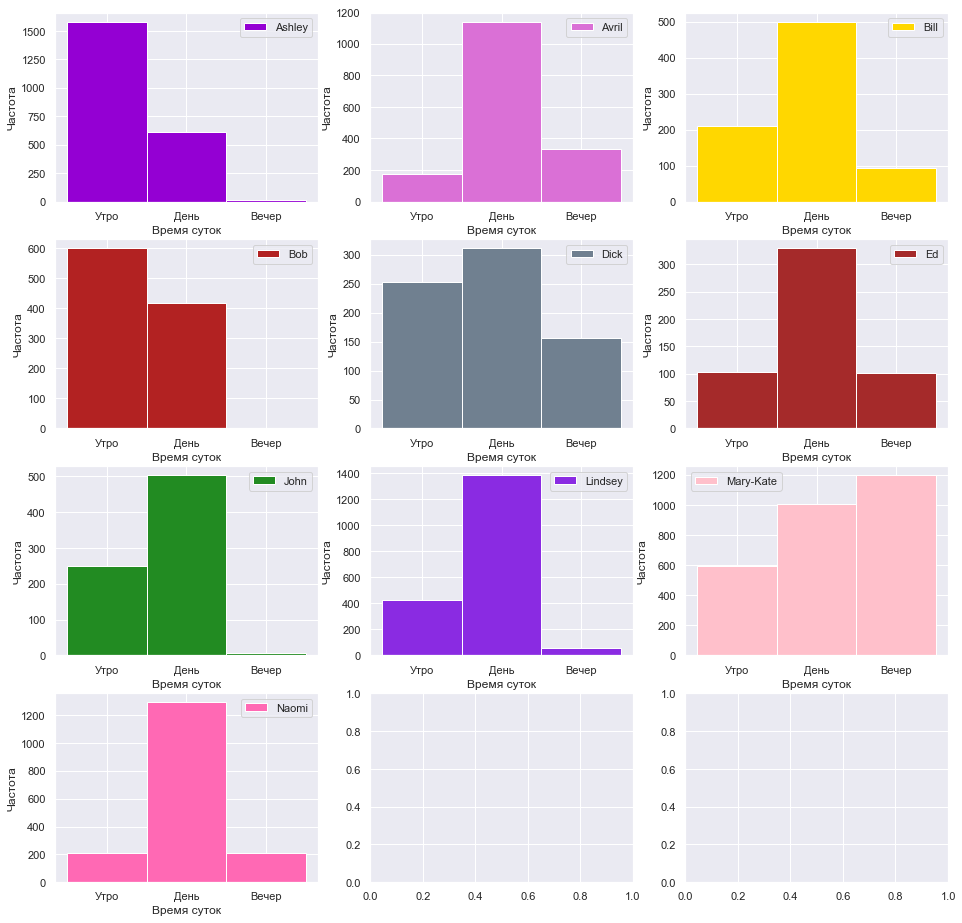

In [676]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))


for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    plt.subplot(4, 3, idx+1)
    plt.hist(sub_df ['time'], bins =  np.arange(-0.5,3.5,1), color = color_dic[user])
    plt.xlabel(u'Время суток')
    plt.ylabel(u'Частота')
    plt.xticks(range(3), [u'Утро', u'День', u'Вечер'])
    plt.legend ([user])
    plt.grid(True)

Видно, что в целом пользователи предпочитают дневное время для выхода в интернет, но у каждого польователя свои предпочтения по времени суток. Признак оставляем.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

На мой взгляд, число уникальных сайтов не очень информативный признак, пользователи похожи, пики на 1-2 сайтах есть у 4 из 10, и пока не будем рассмтривать timediff... Хотя нужно пробовать, если что - вернем. Остальные признаки оставляем.

In [54]:
new_features_10users.head()

,youtube_portion,time,user_id,target
0,0.0,0,31,John
1,0.0,0,31,John
2,0.0,0,31,John
3,0.0,0,31,John
4,0.0,0,31,John


In [57]:
selected_features_10users = pd.concat([train_data_10users [['session_timespan',  'start_hour', 
                 'day_of_week']], new_features_10users [['youtube_portion'
                                                   ,'time']]], axis = 1)
selected_features_150users =   pd.concat([train_data_150users [['session_timespan',  'start_hour', 
                 'day_of_week']], new_features_150users [['youtube_portion'
                                                   ,'time',]]], axis = 1)

In [58]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 

In [ ]:
#labels = data_10users['target'].map(color_dic)

In [584]:
top10_sites = list(site_freq_10) [:30]
top10_freqs =  [site_freq_10 [key][1] for key in top10_sites]
print (list(zip(top10_sites,top10_freqs)))

[('s.youtube.com', 8300), ('www.google.fr', 7813), ('www.google.com', 5441), ('mail.google.com', 4158), ('www.facebook.com', 4141), ('apis.google.com', 3758), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 3244), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 3094), ('plus.google.com', 2630), ('accounts.google.com', 2089), ('r2---sn-gxo5uxg-jqbe.googlevideo.com', 1939), ('fr-mg42.mail.yahoo.com', 1868), ('www.youtube.com', 1804), ('r4---sn-gxo5uxg-jqbe.googlevideo.com', 1702), ('clients1.google.com', 1493), ('download.jboss.org', 1441), ('s-static.ak.facebook.com', 1388), ('static.ak.facebook.com', 1265), ('i1.ytimg.com', 1232), ('twitter.com', 1204), ('accounts.youtube.com', 1057), ('platform.twitter.com', 1041), ('clients6.google.com', 1039), ('safebrowsing-cache.google.com', 1039), ('translate.google.fr', 1002), ('api.twitter.com', 982), ('accounts.google.fr', 974), ('talkgadget.google.com', 965), ('mts0.google.com', 763), ('clients2.google.com', 748)]


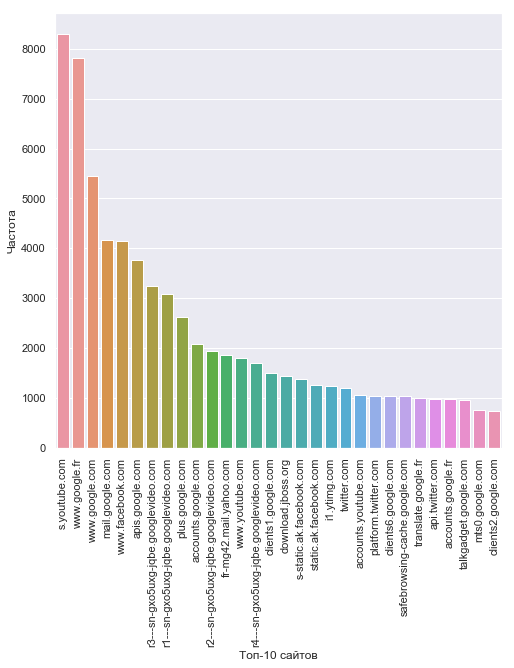

In [585]:
sns.set(rc={'figure.figsize':(8,8)})
sns.barplot ( x = top10_sites , y = top10_freqs  )
plt.xlabel(u'Топ-10 сайтов')
plt.ylabel(u'Частота')
plt.xticks(rotation='vertical')
plt.show()